In [1]:
import os
import sys
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import norm

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = "/".join(current_path.split("/")[:-2]) + "/"

# location folders
data_in = dirname + "da_data_repo/cps-earnings/clear/"
data_out = dirname + "da_case_studies/ch09-gender-age-earnings/"
output = dirname + "da_case_studies/ch09-gender-age-earnings/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
data_all = pd.read_csv(data_in + "morg-2014-emp.csv")

In [5]:
# SELECT OCCUPATION
# keep only two occupation types: Market research analysts and marketing specialists
# and Computer and Mathematical Occupations
data_all.loc[data_all["occ2012"] == 735, "sample"] = 1
data_all.loc[
    ((data_all["occ2012"] >= 1005) & (data_all["occ2012"] <= 1240)), "sample"
] = 2
data_all.loc[data_all["sample"].isna(), "sample"] = 0

In [6]:
data_all = data_all.loc[
    (data_all["sample"] == 1) | (data_all["sample"] == 2), :
].reset_index(drop=True)

In [7]:
data_all.head()

,Unnamed: 0,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,...,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94,sample
0,33,731019430119001,January,AL,2992.1015,1538.46,40,43,2,NaN,...,0,"Native, Born In US",63,"Electric power generation, transmission and di...",1006,"Private, For Profit",No,No,Employed-At Work,2.0
1,346,673032906039520,January,AK,411.5571,1346.15,40,39,3,NaN,...,0,"Native, Born In US",94,Executive offices and legislative bodies (9211...,1030,Government - Local,No,No,Employed-At Work,2.0
2,651,207004430306994,January,AZ,3410.8853,2500.00,40,44,4,NaN,...,0,"Foreign Born, US Cit By Naturalization",86,Computer systems design and related services (...,1020,"Private, For Profit",No,No,Employed-At Work,2.0
3,657,236096309400800,January,AZ,3916.3279,2500.00,40,43,4,NaN,...,10,"Foreign Born, US Cit By Naturalization",86,Business support services (5614),1020,"Private, For Profit",No,No,Employed-At Work,2.0
4,724,914299270769003,January,AZ,5115.4707,1250.00,45,43,1,NaN,...,0,"Native, Born In US",86,Computer systems design and related services (...,1020,"Private, For Profit",No,No,Employed-At Work,2.0


In [8]:
data_all["sample"].value_counts()

2.0    4740
1.0     281
Name: sample, dtype: int64

In [9]:
data_all["female"] = (data_all.sex == 2).astype(int)
data_all["w"] = data_all["earnwke"] / data_all["uhours"]
data_all["lnw"] = np.log(data_all["w"])
data_all["agesq"] = np.power(data_all["age"], 2)

In [10]:
i = 1
data = data_all.loc[data_all["sample"] == i, :].reset_index(drop=True)
data.to_csv(data_out + "earnings_inference.csv", index=False)

In [11]:
#####################
# DISTRIBUTION OF EARNINGS
#######################
data.loc[:, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,281.000000,281.000000,281.000000
mean,1206.186940,40.153025,29.061656
std,709.545222,10.325838,14.712495
min,40.000000,5.000000,7.250000
25%,700.000000,40.000000,17.788250
50%,1096.150000,40.000000,25.950000
75%,1538.000000,40.000000,37.019000
max,2884.610000,80.000000,84.600000


In [12]:
data.loc[data.w >= 1, ["earnwke", "uhours", "w"]].describe()

,earnwke,uhours,w
count,281.000000,281.000000,281.000000
mean,1206.186940,40.153025,29.061656
std,709.545222,10.325838,14.712495
min,40.000000,5.000000,7.250000
25%,700.000000,40.000000,17.788250
50%,1096.150000,40.000000,25.950000
75%,1538.000000,40.000000,37.019000
max,2884.610000,80.000000,84.600000


In [13]:
data["female"].value_counts()

1    172
0    109
Name: female, dtype: int64

In [14]:
data.groupby(["occ2012", "female"]).size()

occ2012  female
735      0         109
         1         172
dtype: int64

In [15]:
##############################
# linear regressions
##############################

# First, look at them one by one

In [16]:
reg1 = smf.ols(formula="lnw~female", data=data).fit()
reg1.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
No. Observations:                 281   F-statistic:                     3.390
Covariance Type:            nonrobust   Prob (F-statistic):             0.0666
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3149      0.048     69.004      0.000       3.220       3.409
female        -0.1131      0.061     -1.841      0.067      -0.234       0.008
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
reg2 = smf.ols(formula="lnw~female", data=data).fit(cov_type="HC1")
reg2.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.008
No. Observations:                 281   F-statistic:                     3.347
Covariance Type:                  HC1   Prob (F-statistic):             0.0684
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3149      0.049     67.810      0.000       3.219       3.411
female        -0.1131      0.062     -1.829      0.067      -0.234       0.008
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [18]:
reg3 = smf.ols(formula="lnw~age", data=data).fit(cov_type="HC1")
reg3.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.095
No. Observations:                 281   F-statistic:                     26.36
Covariance Type:                  HC1   Prob (F-statistic):           5.31e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7317      0.101     27.006      0.000       2.533       2.930
age            0.0135      0.003      5.135      0.000       0.008       0.019
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [19]:
reg4 = smf.ols(formula="lnw~age+agesq", data=data).fit(cov_type="HC1")
reg4.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.163
No. Observations:                 281   F-statistic:                     27.47
Covariance Type:                  HC1   Prob (F-statistic):           1.29e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1935      0.341      3.499      0.000       0.525       1.862
age            0.0962      0.018      5.360      0.000       0.061       0.131
agesq         -0.0010      0.000     -4.608      0.000      -0.001      -0.001
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 2.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
reg5 = smf.ols(formula="lnw~lspline(age,[30,40])", data=data).fit(cov_type="HC1")
reg5.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnw   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.164
No. Observations:                 281   F-statistic:                     19.33
Covariance Type:                  HC1   Prob (F-statistic):           2.07e-11
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.3834      0.369      3.753      0.000       0.661       2.106
lspline(age, [30, 40])[0]     0.0624      0.014      4.559      0.000       0.036       0.089
lspline(age, [30, 40])[1]     0.0165      0.010      1.680      0.093      -0.003       0.036
lspline(age, [30, 40])[2]    -0.0026      0.006     -0.444      0.657      -0.014       0.009
=============================================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [21]:
import statsmodels.nonparametric.kernel_regression as loess

reg6 = loess.KernelReg(data["lnw"], data["age"], var_type="c", reg_type="lc")
# loess.lowess(data['lnw'],data["age"],frac=0.75,return_sorted=False)
# reg6 = localr(y=data["lnw"], x=data["age"],kernel=gaussian,frac=0.75)

In [22]:
reg6

KernelReg instance
Number of variables: k_vars = 1
Number of samples:   N = 281
Variable types:      c
BW selection method: cv_ls
Estimator type: lc

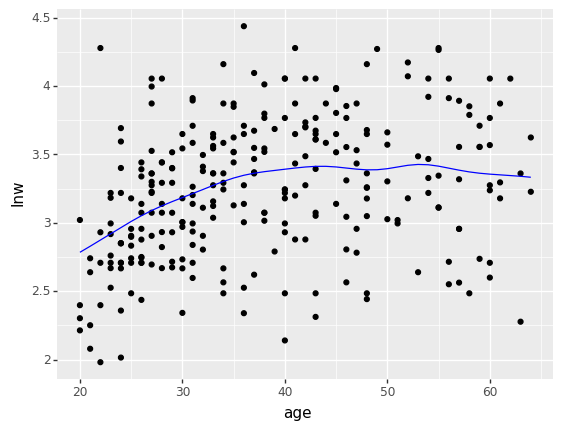

<ggplot: (8790514545336)>

In [23]:
ggplot(data) + geom_point(aes("age", "lnw")) + geom_line(
    aes("age", y=reg6.fit()[0]), color="blue"
)

In [24]:
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer

In [25]:
Stargazer([reg1, reg2])

In [26]:
Stargazer([reg3, reg4, reg5])

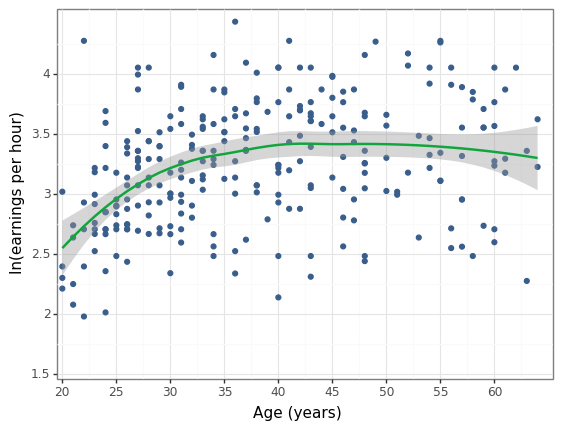

<ggplot: (8790514442225)>

In [27]:
##############################
# graphs
##############################
ggplot(data, aes(x="age", y="lnw")) + geom_point(color=color[0]) + geom_smooth(
    method="loess", color=color[1]
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + theme_bw()

In [28]:
z = reg4.get_prediction().conf_int()

In [29]:
res = reg4.get_prediction().summary_frame()
data["lnwpred_ageq"] = res["mean"]
data["lnwpred_ageqCIUP"] = [x[0] for x in z]
data["lnwpred_ageqCILO"] = [x[1] for x in z]

In [30]:
z = reg5.get_prediction().conf_int()

In [31]:
res = reg5.get_prediction().summary_frame()
data["lnwpred_agesp"] = res["mean"]
data["lnwpred_agespCIUP"] = [x[0] for x in z]
data["lnwpred_agespCILO"] = [x[1] for x in z]

In [32]:
data["lnwpred_agel"] = reg6.fit()[0]

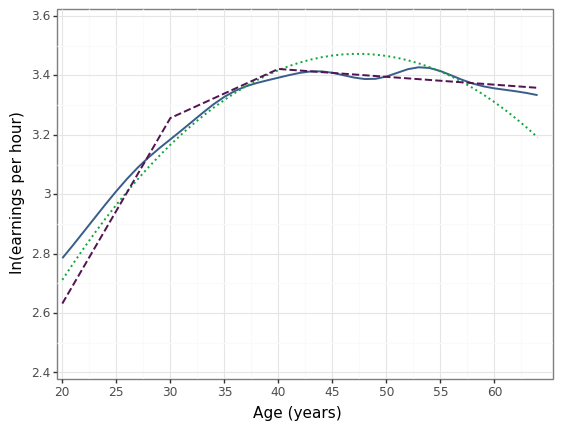

<ggplot: (8790494479770)>

In [33]:
ggplot(data, aes(x="age")) + geom_line(
    data,
    aes(y="lnwpred_agel"),
    color=color[0],
    linetype="solid",
    size=0.8,
    show_legend=True,
) + geom_line(
    data,
    aes(y="lnwpred_ageq"),
    color=color[1],
    linetype="dotted",
    size=0.8,
    show_legend=True,
) + geom_line(
    data,
    aes(y="lnwpred_agesp"),
    color=color[2],
    linetype="dashed",
    size=0.8,
    show_legend=True,
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.4, 3.6), breaks=seq(2.4, 3.6, by=0.20)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + theme_bw() + theme(
    legend_position=(45, 2.6),
    legend_direction="horizontal",
    legend_text=element_text(size=3),
    legend_key_width=0.8,
    legend_key_height=0.2,
) + guides(
    linetype=guide_legend(override_aes=dict(size=0.6))
) + scale_color_discrete(
    name=" ", values=["red", "cyan", "green"]
)

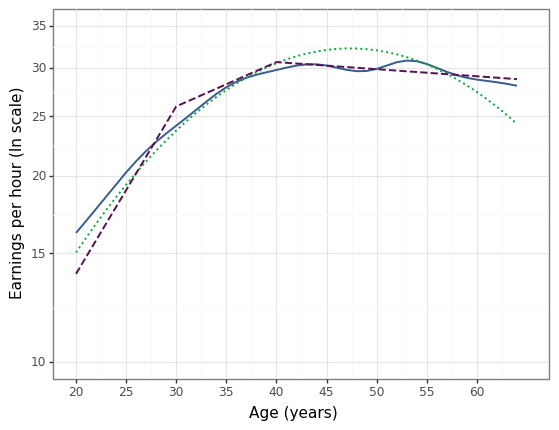

<ggplot: (8790496072647)>

In [34]:
ggplot(data, aes(x="age")) + geom_line(
    aes(y="lnwpred_agel"), color=color[0], linetype="solid", size=0.8
) + geom_line(
    aes(y="lnwpred_ageq"), color=color[1], linetype="dotted", size=0.8
) + geom_line(
    aes(y="lnwpred_agesp"), color=color[2], linetype="dashed", size=0.8,
) + scale_color_manual(
    name="", values=[color[0], color[1], color[2]]
) + scale_linetype_manual(
    name="", values=("solid", "dashed", "dotted")
) + scale_x_continuous(
    limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    limits=(2.302585093, 3.555348061),
    breaks=(
        2.302585093,
        2.708050201,
        2.995732274,
        3.218875825,
        3.401197382,
        3.555348061,
    ),
    labels=(10, 15, 20, 25, 30, 35),
) + labs(
    x="Age (years)", y="Earnings per hour (ln scale)"
) + theme_bw() + theme(
    legend_position=(0.65, 0.1),
    legend_direction="horizontal",
    legend_text=element_text(size=4),
    legend_key_width=0.8,
    legend_key_height=0.2,
) + guides(
    linetype=guide_legend(override_aes=dict(size=0.6))
)

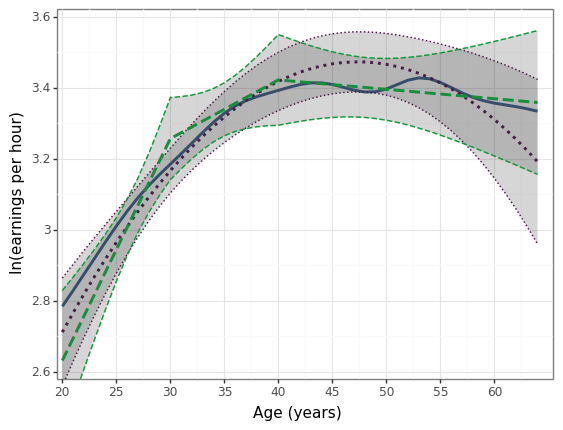

<ggplot: (8790494477837)>

In [35]:
ggplot(data, aes(x="age")) + geom_line(
    aes(y="lnwpred_agel"), color=color[0], linetype="solid", size=1.2
) + geom_line(
    aes(y="lnwpred_ageq"), color=color[2], linetype="dotted", size=1.2
) + geom_line(
    aes(y="lnwpred_ageqCIUP"), color=color[2], linetype="dotted", size=0.6
) + geom_line(
    aes(y="lnwpred_ageqCILO"), color=color[2], linetype="dotted", size=0.6
) + geom_ribbon(
    aes(ymin="lnwpred_ageqCILO", ymax="lnwpred_ageqCIUP"), alpha=0.2,
) + geom_line(
    aes(y="lnwpred_agesp"), color=color[1], linetype="dashed", size=1.2,
) + geom_line(
    aes(y="lnwpred_agespCIUP"), color=color[1], linetype="dashed", size=0.6,
) + geom_line(
    aes(y="lnwpred_agespCILO"), color=color[1], linetype="dashed", size=0.6,
) + geom_ribbon(
    aes(ymin="lnwpred_agespCILO", ymax="lnwpred_agespCIUP"), alpha=0.2
) + coord_cartesian(
    xlim=(20, 65), ylim=(2.6, 3.6)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(2.4, 3.6), breaks=seq(2.4, 3.6, by=0.20)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + scale_color_manual(
    name="", values=(color[1], color[2], color[3])
) + scale_linetype_manual(
    name="", values=("solid", "dashed", "dotted")
) + theme_bw() + theme(
    legend_position=(0.65, 0.1),
    legend_direction="horizontal",
    legend_text=element_text(size=4),
    legend_key_width=0.8,
    legend_key_height=0.2,
) + guides(
    linetype=guide_legend(override_aes=dict(size=0.6))
)

In [36]:
##########################################
# CI and PI for the linear model
##########################################
reg7 = smf.ols(formula="lnw~age", data=data.loc[data["sample"] == 1,]).fit()

In [37]:
pred_confidence = data.join(
    pd.DataFrame(reg7.get_prediction().conf_int(), columns=["lwr", "upr"])
).join(reg7.get_prediction().summary_frame()["mean"].rename("fit"))

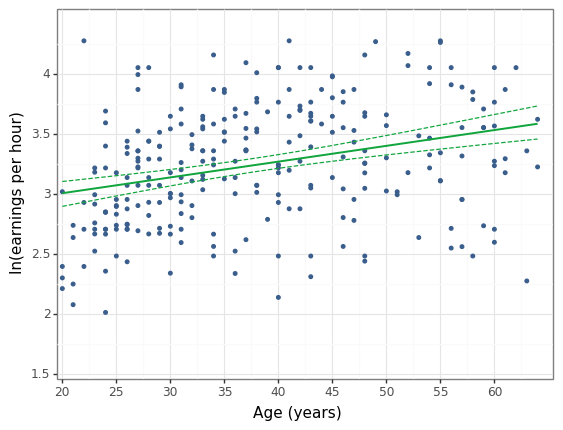

<ggplot: (8790494355469)>

In [38]:
ggplot(pred_confidence.query("lnw<4.4 & lnw>2"), aes(x="age", y="lnw")) + geom_point(
    color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(
    method="lm", colour=color[1], se=False, size=0.8, linetype="solid"
) + geom_line(
    pred_confidence, aes(x="age", y="lwr"), size=0.5, linetype="dashed", colour=color[1]
) + geom_line(
    pred_confidence, aes(x="age", y="upr"), size=0.5, linetype="dashed", colour=color[1]
) + coord_cartesian(
    xlim=(20, 65), ylim=(1.5, 4.5)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + scale_linetype_manual(
    name="",
    values=(1, 1, 2),
    labels=("Lowess", "Confidence interval (95%)", "Confidence interval (95%)"),
) + theme_bw()

In [39]:
pred_interval = data
pred_interval[["lwr", "upr"]] = (
    reg7.get_prediction().summary_frame().loc[:, ["obs_ci_lower", "obs_ci_upper"]]
)
pred_interval = pred_interval.join(
    reg7.get_prediction().summary_frame()["mean"].rename("fit")
)

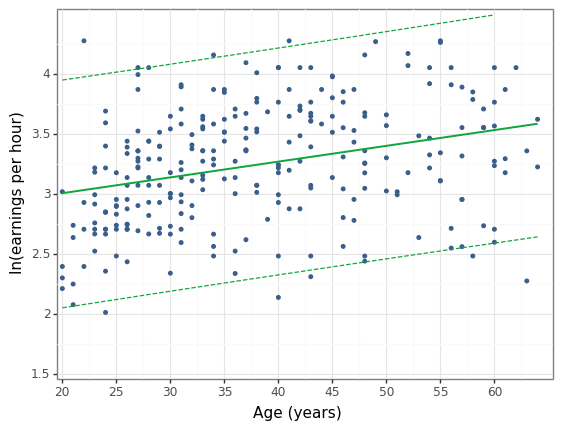

<ggplot: (8790514441991)>

In [40]:
ggplot(pred_interval.query("lnw<4.4 & lnw>2"), aes(x="age", y="lnw")) + geom_point(
    color=color[0], size=1, alpha=0.8, show_legend=False, na_rm=True
) + geom_smooth(
    method="lm", colour=color[1], se=False, size=0.8, linetype="solid"
) + geom_line(
    pred_interval, aes(y="lwr"), size=0.5, linetype="dashed", colour=color[1]
) + geom_line(
    pred_interval, aes(y="upr"), size=0.5, linetype="dashed", colour=color[1]
) + coord_cartesian(
    xlim=(20, 65), ylim=(1.5, 4.5)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(20, 65), breaks=seq(20, 65, by=5)
) + scale_y_continuous(
    expand=(0.01, 0.01), limits=(1.5, 4.5), breaks=seq(1.5, 4.5, by=0.50)
) + labs(
    x="Age (years)", y="ln(earnings per hour)"
) + theme_bw()

In [41]:
data = pd.read_csv(data_out + "earnings_inference.csv")

In [42]:
def bs_linreg(x, y, size=1, seed=200999):
    """Perform pairs bootstrap for linear regression."""
    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize samples
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    np.random.seed(seed)
    # Take samples
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds), replace=True)
        bs_x, bs_y = sm.add_constant(x[bs_inds]), y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = (
            sm.regression.linear_model.OLS(bs_y, bs_x).fit().params
        )

    return bs_slope_reps, bs_intercept_reps

In [43]:
results = bs_linreg(data.lnw.values, data.female.values, size=1000)

b_earnings_female = pd.DataFrame(results).T

b_earnings_female.columns = ["_b_intercept", "_b_female"]

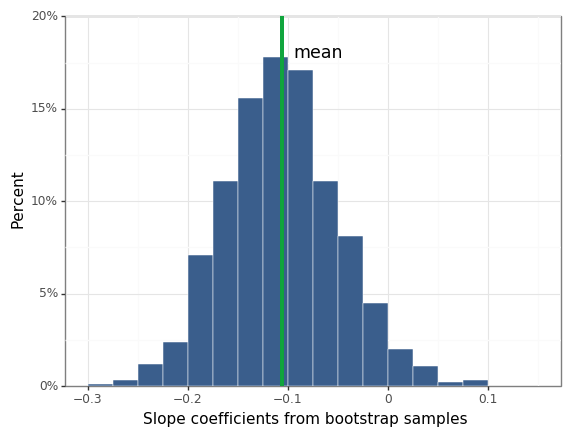

<ggplot: (8790494436937)>

In [44]:
ggplot(b_earnings_female, aes(x="_b_female")) + geom_histogram(
    aes(y="stat(count)/sum(stat(count))"),
    binwidth=0.025,
    center=0.0125,
    closed="left",
    color="white",
    fill=color[0],
    size=0.2,
    alpha=0.8,
    show_legend=False,
    na_rm=True,
) + geom_segment(
    aes(
        x=b_earnings_female["_b_female"].mean(),
        y=0,
        xend=b_earnings_female["_b_female"].mean(),
        yend=0.2,
    ),
    colour=color[1],
    size=1,
) + annotate(
    "text", x=-0.07, y=0.18, label="mean", size=12.5
) + coord_cartesian(
    xlim=(-0.3, 0.15), ylim=(0, 0.2)
) + labs(
    x="Slope coefficients from bootstrap samples", y="Percent"
) + scale_y_continuous(
    expand=(0.0, 0.0), limits=(0, 0.2), labels=percent_format()
) + theme_bw()